In [60]:
#This code needs to run in a baseband-analysis docker container on frb-analysis
import argparse
import os
import warnings
from datetime import datetime
from glob import glob

import numpy as np
from ch_util import ephemeris, tools

import baseband_analysis.analysis.beamform as beamform
import baseband_analysis.core.bbdata as bbdata
import baseband_analysis.core.calibration as cal
from baseband_analysis.utilities import layout
from baseband_analysis.pipelines.config import (
    chime_backend,
    freq_id_from_filename,
    get_event_date,
    tone_backend,
)

In [61]:
import logging
import os

import ch_util
import chime_frb_constants as constants
import chimedb.core
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tenacity
from beam_model.utils import get_equatorial_from_position, get_position_from_equatorial
from ch_util import tools
from frb_common.common_utils import delay_across_the_band
from scipy.fft import fft, fftfreq, fftshift
from caput import memh5

from baseband_analysis.core._accel import tiedbeam_apply_phase_sum
from baseband_analysis.utilities import layout
import logging as log
log.basicConfig(level=logging.INFO)


## The params passed to outrigger_beamform.py

In [62]:
event_id = 159740851
telescope = "chime"
#Should be given in ICRS J2000. Passing Crab coords from now (taken from Simbad)
ra = 83.63311446 
dec = 22.01448714
transit_dec = 99.0
max_targets = 7 #No. of calibrators
#cal_h5 = ? Not doing calibration as of now.

In [63]:
backend = chime_backend
pattern = backend.get_raw_files(event_id)

[2022-05-27 22:36:57,986] INFO Reauthorize Method: Tokens
[2022-05-27 22:36:58,032] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2022-05-27 22:36:58,033] INFO Reauthorize Result: Passed
[2022-05-27 22:36:58,034] INFO Authorization Status: None
[2022-05-27 22:36:58,035] INFO Authorization Method: Tokens
[2022-05-27 22:36:58,054] INFO Authorization Result: Passed
[2022-05-27 22:36:58,055] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().


/data/chime/baseband/raw/2021/02/18/astro_159740851/*.h5


In [64]:
len(glob('/data/chime/baseband/raw/2021/02/18/astro_159740851/*.h5'))

948

## beamfrom_outrigger function

In [65]:
#Get date and time from the first frame, i.e, the first freq id. 
filenames = glob(pattern)
filenames.sort(key=freq_id_from_filename)
first_data = bbdata.BBData.from_acq_h5(filenames[0])

date_unix = first_data["time0"]["ctime"][0]

date = datetime.utcfromtimestamp(date_unix)

In [66]:
date

datetime.datetime(2021, 2, 18, 3, 36, 41, 449999)

In [67]:
date_unix #Uisng this unix time to compute hour angle, inputting this time in the real time beamformer.

1613619401.4499993

In [68]:
#Computing lsa and lst from the date_unix
obs=ephemeris.chime
lsa = obs.unix_to_lsa(np.array([date_unix]))
lst = obs.unix_to_lst(np.array([date_unix]))
print("lsa = {}, lst = {}".format(lsa, lst))

lsa = [82.60568733], lst = [82.87247756]


In [69]:
#CHIME Antenna positions
inputs = layout.get_correlator_inputs(date, correlator=backend.name)

In [70]:
#Phase center = 0, 0, 0 
static_phase_center = tools.ArrayAntenna(id=-1, slot=-1, powered=True, flag=True, pos=[0, 0, 0], delay=0)
static_phase_center

ArrayAntenna(id=-1, delay=0, input_sn=None, corr=None, reflector=None, antenna=None, rf_thru=None, cyl=None, pol=None, flag=True, pos=[0.00, 0.00, 0.00])

In [71]:
#The piece of code taken from the delay function in ch_util/tools.py which computes the HA
src = ch_util.ephemeris.skyfield_star_from_ra_dec(ra, dec) #ra and dec should be in J2000 ICRS frame
print(src)
obs=ephemeris.chime
ra = obs.unix_to_lsa(np.array([date_unix])) #Compute lsa for the date_unix
src_ra, src_dec = ephemeris.object_coords(src, np.array([date_unix]), obs=obs) #Computes RA and DEC wrt the CIO.
print("lsa = {}".format(ra))
print("ra = {}, dec= {}".format(np.degrees(src_ra), np.degrees(src_dec)))
ha = (np.radians(ra) - src_ra)[np.newaxis, :]
print("HA = {}".format(np.degrees(ha)))

Star(ra=83.63311446, dec=22.01448714, epoch=2451545.0)
lsa = [82.60568733]
ra = [83.6824197], dec= [22.02772144]
HA = [[-1.07673237]]


## tied_array function

In [30]:
data = first_data
correlator_inputs=inputs
reference_feed=static_phase_center
TOA_400=None
telescope_rotation=None
DM=None
source_name=None

In [31]:
ra, dec = (
    np.asarray(ra, dtype=float).reshape(-1),
    np.asarray(dec, dtype=float).reshape(-1),
)

inputs = list(correlator_inputs)

converted_data_inputs = data.input.astype(
    [("chan_id", "<u2"), ("correlator_input", "U32")]
)

# Reorder to match the data, if using a cylinder.

if ch_util.tools.PathfinderAntenna in [
    type(input) for input in inputs
] or ch_util.tools.CHIMEAntenna in [type(input) for input in inputs]:
    reordered_inputs = ch_util.tools.reorder_correlator_inputs(
        converted_data_inputs, inputs
    )

prod_map = np.empty(len(data.input), dtype=[("input_a", "u2"), ("input_b", "u2")])
prod_map["input_a"] = np.arange(len(data.input))

if type(reference_feed) is int:
    # Use the internal location: (0,1,2,...N) x (reference_feed) is the prod map
    prod_map["input_b"] = reference_feed
else:
    if not isinstance(reference_feed, tools.ArrayAntenna):
        raise AssertionError
    # Use the external location:
    # prod_map still has 256 baselines, and so does the data.
    # but, the input list now has an external feed
    reordered_inputs.append(reference_feed)
    prod_map["input_b"] = len(data.input)

nfreq = data.nfreq
ntime = data.ntime
ninput = data.ninput
npointings = ra.size
nbeam = npointings * 2  # 2 polarizations.

pol_mask = np.zeros((2, ninput), dtype=np.int32)
for ii in range(ninput):
    if not isinstance(reordered_inputs[ii], ch_util.tools.ArrayAntenna):
        continue
    elif reordered_inputs[ii].pol == "S":
        pol_mask[0, ii] = 1
    elif reordered_inputs[ii].pol == "E":
        pol_mask[1, ii] = 1

log.info("    -- Creating dataset")

# TODO: bad naming, change d to something descriptive
#d = data.create_dataset(
#    "tiedbeam_baseband", shape=(nfreq, nbeam, ntime), dtype=data.baseband.dtype
#)
#beam_axis = _make_beammap(data, nbeam)
#d.attrs["axis"] = ["freq", beam_axis, "time"]
#memh5.copyattrs(data["baseband"].attrs, d.attrs)

#ib_dtype = [
#    ("ra", float),
#    ("dec", float),
#    ("x_400MHz", float),
#    ("y_400MHz", float),
#    ("pol", "S1"),
#]
#if source_name is not None:
#    ib_dtype.append(("source_name", "<S20"))
#ib = np.empty(nbeam, dtype=ib_dtype)
#ib["ra"] = (ra[:, None] * np.ones(2, dtype=ra.dtype)).flat
#ib["dec"] = (dec[:, None] * np.ones(2, dtype=dec.dtype)).flat

# Calculate local coordinates
# TODO: is this truly 400 MHz?
#if TOA_400 is None:
#    time = data["time0"]["ctime"][-1] + data["time0"]["ctime_offset"][-1]
#    time = time + np.mean(data.index_map["time"]["offset_s"])
#else:
#    time = TOA_400

#x, y = get_position_from_equatorial(ra, dec, time, telescope_rotation_angle=None)
#ib["x_400MHz"] = (x[:, None] * np.ones(2, dtype=x.dtype)).flat
#ib["y_400MHz"] = (y[:, None] * np.ones(2, dtype=y.dtype)).flat
#ib["pol"] = ["S", "E"] * npointings
#if source_name is not None:
#    ib["source_name"] = [y for x in source_name for y in (x,) * 2]
#loc = data.create_dataset("tiedbeam_locations", data=ib)
#loc.attrs["axis"] = [beam_axis]

log.info("    -- Processing each channel")
for jjfreq in range(nfreq):
    # Time is frequency dependent due to substantial dispersion delay
    if TOA_400 is None:
        time = (
            data["time0"]["ctime"][jjfreq] + data["time0"]["ctime_offset"][jjfreq]
        )
        time = time + np.mean(data.index_map["time"]["offset_s"])
    else:
        time = TOA_400 + common_utils.delay_across_the_band(
            DM, data.freq[jjfreq], 400.0
        )

    log.info(f"      --- Frequency n. {jjfreq}: Exctracting channel")
    array_baseband = data.baseband[jjfreq : jjfreq + 1]
    log.info(f"      --- Frequency n. {jjfreq}: Forming single beams")
    for iipoint in range(npointings):
        src = ch_util.ephemeris.skyfield_star_from_ra_dec(ra[iipoint], dec[iipoint])
        log.debug(f"        ---- Pointing n. {iipoint}: Start fringestopping")
        # Here we assume the beamforming phase does not depend on time, since
        # baseband dumps are typically very short (less than a second at a single frequency).
        # Thus we only need to calculate one set of phases.
        fringestop_phase = (
            ch_util.tools.fringestop_time(
                np.ones(array_baseband.shape[:-1] + (1,), array_baseband.dtype),
                np.array([time]),
                data.freq[[jjfreq]],
                reordered_inputs,
                src,
                prod_map=prod_map,
            )
            .astype(np.complex64)
            .conj()
        )

#        log.debug(f"        ---- Pointing n. {iipoint}: Start summing")
#        beams = tiedbeam_apply_phase_sum(
#            array_baseband[0], fringestop_phase[0, :, 0], pol_mask
#        )
#        log.debug(f"        ---- Pointing n. {iipoint}: Writing to database")
#        d[jjfreq, 2 * iipoint : 2 * (iipoint + 1), :] = beams
#d.attrs["conjugate_beamform"] = int(1)
#log.info("    -- Beamforming finished")


[2022-05-24 18:02:18,140] INFO     -- Creating dataset
[2022-05-24 18:02:18,141] INFO     -- Processing each channel
[2022-05-24 18:02:18,142] INFO       --- Frequency n. 0: Exctracting channel
[2022-05-24 18:02:18,143] INFO       --- Frequency n. 0: Forming single beams


In [46]:
#Compare the astropy routine and object_coords to get CIRS coords
import astropy.units as u                                               
from astropy.coordinates import EarthLocation, SkyCoord, CIRS           
from astropy.time import Time                                           
chime = EarthLocation(lat=49.3207092194*u.deg, lon=-119.6236774310*u.deg, height=555.372*u.m)                                                   
time = Time(59093.5672, format="mjd") 
coord = SkyCoord("19:00:45.34", "+46:34:44.23", unit=(u.hour, u.deg))
coord.transform_to(CIRS(obstime=time)) 

<SkyCoord (CIRS: obstime=59093.5672): (ra, dec) in deg
    (285.07781646, 46.61291933)>

In [50]:
fringestop_phase

array([[[ 0.8400009 -0.5425849j ],
        [-0.974437  -0.22466105j],
        [ 0.5176437 +0.8555963j ],
        ...,
        [-0.298379  -0.95444745j],
        [-0.47688967+0.8789632j ],
        [ 0.9628106 -0.27017727j]]], dtype=complex64)

In [51]:
reordered_inputs

[CHIMEAntenna(id=204, crate=0, slot=0, sma=12, corr_order=0, delay=0, input_sn='FCC000012', corr='FCC', reflector='cylinder_A', antenna='ANT0842H', rf_thru='BKR0AC_A28', cyl=2, pol='S', flag=True, pos=[-32.97, 23.36, 0.00]),
 CHIMEAntenna(id=205, crate=0, slot=0, sma=13, corr_order=1, delay=0, input_sn='FCC000013', corr='FCC', reflector='cylinder_A', antenna='ANT0734H', rf_thru='BKR0AC_A29', cyl=2, pol='S', flag=True, pos=[-32.97, 23.66, 0.00]),
 CHIMEAntenna(id=206, crate=0, slot=0, sma=14, corr_order=2, delay=0, input_sn='FCC000014', corr='FCC', reflector='cylinder_A', antenna='ANT0727H', rf_thru='BKR0AC_A30', cyl=2, pol='S', flag=True, pos=[-32.97, 23.97, 0.00]),
 CHIMEAntenna(id=207, crate=0, slot=0, sma=15, corr_order=3, delay=0, input_sn='FCC000015', corr='FCC', reflector='cylinder_A', antenna='ANT0729H', rf_thru='BKR0AC_A31', cyl=2, pol='S', flag=True, pos=[-32.97, 24.27, 0.00]),
 CHIMEAntenna(id=200, crate=0, slot=0, sma=8, corr_order=4, delay=0, input_sn='FCC000008', corr='FCC

In [52]:
for i in reordered_inputs:
    print(type(i))

<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.Blank'>
<class 'ch_util.tools.CHIMEAntenna'>
<class '

<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<class 'ch_util.tools.CHIMEAntenna'>
<

In [53]:
type(reordered_inputs[1])

ch_util.tools.CHIMEAntenna

In [54]:
x_pos = []
y_pos = []
ant_id = []
for i in range(len(reordered_inputs)):
    if type(reordered_inputs[i]) == ch_util.tools.Blank or type(reordered_inputs[i]) == ch_util.tools.NoiseSource:
        continue
    else:
        x_pos.append(reordered_inputs[i].pos[0])
        y_pos.append(reordered_inputs[i].pos[1])
        ant_id.append(reordered_inputs[i].id)

In [55]:
fringestop_phase[0][128]

array([0.90795255-0.41907305j], dtype=complex64)

Text(0.5, 1.0, 'Positions of CHIME feeds wrt the phase center')

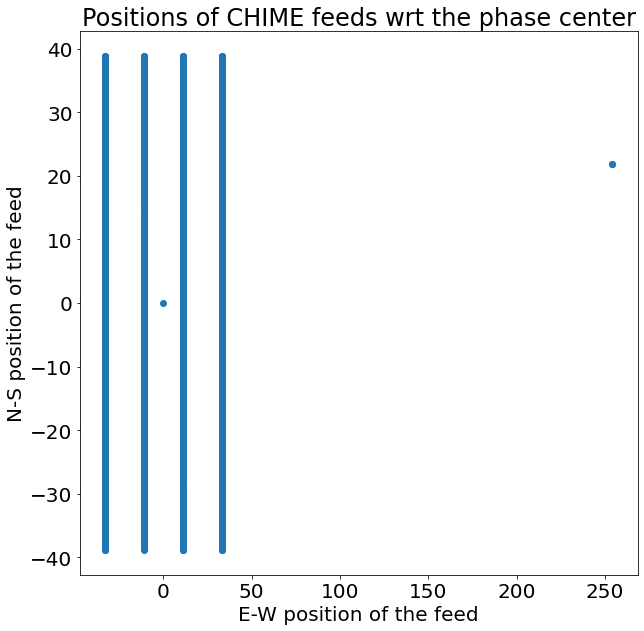

In [56]:
plt.scatter(x_pos,y_pos)
plt.xlabel("E-W position of the feed")
plt.ylabel("N-S position of the feed")
plt.title("Positions of CHIME feeds wrt the phase center")

In [431]:
count = 0
count_blank = 0
for i in range(len(reordered_inputs)):
    if type(reordered_inputs[i]) == ch_util.tools.Blank or type(reordered_inputs[i]) == ch_util.tools.NoiseSource:
        if reordered_inputs[i].id<512:
            print(i)
            count_blank+=1
    elif reordered_inputs[i].id<512:
        count+=1
    elif reordered_inputs[i].id>=512:
        print(reordered_inputs[i].id)
        print(i)
        break
print("Count = {}".format(count))
print(count_blank)

25
192
206
258
560
512
Count = 508
4


In [432]:
ant_id[508]

560

In [433]:
len(fringestop_phase[0])

2048

In [434]:
fringestop_phase[0][1].imag

array([-0.22466105], dtype=float32)

In [435]:
len(reordered_inputs)

2049

### Finding the feed with x pos > 200 and x pos = 0

In [436]:
for i in range(len(x_pos)):
    if x_pos[i] > 200 or x_pos[i] == 0:
        print(ant_id[i])

1225
1521
-1


In [437]:
for i in range(len(reordered_inputs)):
    if reordered_inputs[i].id == 1225 or reordered_inputs[i].id == 1521 or reordered_inputs[i].id == -1:
        print(i)
        print(reordered_inputs[i])

1285
HolographyAntenna(id=1225, crate=5, slot=0, sma=9, corr_order=1285, delay=1.475e-06, input_sn='FCC050009', corr='FCC', reflector='26m_dish', antenna='ANT0209C', rf_thru='BKR0CC_A09', pos=[254.162124, 21.853934, 20.0], pol='S')
1405
HolographyAntenna(id=1521, crate=5, slot=7, sma=1, corr_order=1405, delay=1.475e-06, input_sn='FCC050701', corr='FCC', reflector='26m_dish', antenna='ANT0209C', rf_thru='BKR0CC_H01', pos=[254.162124, 21.853934, 20.0], pol='E')
2048
ArrayAntenna(id=-1, delay=0, input_sn=None, corr=None, reflector=None, antenna=None, rf_thru=None, cyl=None, pol=None, flag=True, pos=[0.00, 0.00, 0.00])


In [438]:
for i in range(len(reordered_inputs)):
    if reordered_inputs[i].id == 0 or reordered_inputs[i].id == 255 or reordered_inputs[i].id == 256 or reordered_inputs[i].id == 511:
        print(i)
        print(reordered_inputs[i].id)
        print(reordered_inputs[i].pos)
        #print(reordered_inputs[i].pol)
        print(fringestop_phase[0][i])

99
255
[-32.95181751568965, 38.902863216127024, 0.0]
[0.8203445-0.5718697j]
115
511
[-32.95181751568965, 38.902863216127024, 0.0]
[0.8203445-0.5718697j]
128
0
[-33.04813181029521, -38.82107710831004, 0.0]
[0.90795255-0.41907305j]
144
256
[-33.04813181029521, -38.82107710831004, 0.0]
[0.90795255-0.41907305j]


### FInd all Blank/Noise sources which have phases = 0

In [439]:
blank_noise_index = []
blank_noise_id = []
for i in range(len(reordered_inputs)):
    if type(reordered_inputs[i]) == ch_util.tools.Blank or type(reordered_inputs[i]) == ch_util.tools.NoiseSource:
        print("Index = {}".format(i))
        print(reordered_inputs[i])
        blank_noise_index.append(i)
        blank_noise_id.append(reordered_inputs[i].id)

Index = 25
Blank(id=453, crate=0, slot=1, sma=5, corr_order=25, delay=0, input_sn='FCC000105', corr='FCC')
Index = 192
NoiseSource(id=32, crate=0, slot=12, sma=12, corr_order=192, delay=0, input_sn='FCC001212', corr='FCC')
Index = 206
NoiseSource(id=46, crate=0, slot=12, sma=2, corr_order=206, delay=0, input_sn='FCC001202', corr='FCC')
Index = 258
NoiseSource(id=142, crate=1, slot=0, sma=14, corr_order=258, delay=0, input_sn='FCC010014', corr='FCC')
Index = 624
NoiseSource(id=768, crate=2, slot=7, sma=12, corr_order=624, delay=0, input_sn='FCC020712', corr='FCC')
Index = 764
NoiseSource(id=960, crate=2, slot=15, sma=0, corr_order=764, delay=0, input_sn='FCC021500', corr='FCC')
Index = 782
Blank(id=638, crate=3, slot=0, sma=2, corr_order=782, delay=0, input_sn='FCC030002', corr='FCC')
Index = 908
NoiseSource(id=688, crate=3, slot=8, sma=0, corr_order=908, delay=0, input_sn='FCC030800', corr='FCC')
Index = 924
Blank(id=944, crate=3, slot=9, sma=0, corr_order=924, delay=0, input_sn='FCC03

In [440]:
len(fringestop_phase[0])

2048

In [441]:
len(reordered_inputs)

2049

In [442]:
fringestop_phase[0][128]

array([0.90795255-0.41907305j], dtype=complex64)

In [443]:
fringestop_phase[0][144]

array([0.90795255-0.41907305j], dtype=complex64)

In [444]:
for i in range(len(reordered_inputs)):
    if reordered_inputs[i].id == 127 or reordered_inputs[i].id == 128:
        print(i)
        print(reordered_inputs[i])

268
CHIMEAntenna(id=128, crate=1, slot=0, sma=0, corr_order=268, delay=0, input_sn='FCC010000', corr='FCC', reflector='cylinder_A', antenna='ANT1133H', rf_thru='BKR0AC_A00', cyl=2, pol='S', flag=True, pos=[-33.00, 0.19, 0.00])
495
CHIMEAntenna(id=127, crate=1, slot=14, sma=3, corr_order=495, delay=0, input_sn='FCC011403', corr='FCC', reflector='cylinder_A', antenna='ANT1289H', rf_thru='BKR0AC_Q03', cyl=2, pol='S', flag=True, pos=[-33.00, -0.11, 0.00])


### Getting the positions for all feeds id wise 

In [445]:
feed = 0
cylA = []
cylA_phases = []
while(feed < 256):
    for i in range(len(reordered_inputs)):
        if reordered_inputs[i].id == feed:
            if type(reordered_inputs[i]) == ch_util.tools.Blank or type(reordered_inputs[i]) == ch_util.tools.NoiseSource:
                cylA.append([0,0])
            else:
                cylA.append([reordered_inputs[i].pos[0], reordered_inputs[i].pos[1]])
            cylA_phases.append(fringestop_phase[0][i])
            feed +=1
            break
        

In [446]:
cylA

[[-33.04813181029521, -38.82107710831004],
 [-33.04775410717911, -38.51627734233186],
 [-33.04737640406301, -38.21147757635368],
 [-33.04699870094691, -37.90667781037549],
 [-33.04662099783081, -37.60187804439731],
 [-33.04624329471471, -37.29707827841912],
 [-33.045865591598606, -36.99227851244094],
 [-33.045487888482505, -36.68747874646275],
 [-33.045110185366404, -36.38267898048457],
 [-33.04473248225031, -36.07787921450638],
 [-33.04435477913421, -35.7730794485282],
 [-33.04397707601811, -35.46827968255001],
 [-33.04359937290201, -35.16347991657183],
 [-33.04322166978591, -34.85868015059364],
 [-33.04284396666981, -34.55388038461546],
 [-33.042466263553706, -34.24908061863727],
 [-33.042088560437605, -33.94428085265909],
 [-33.041710857321505, -33.6394810866809],
 [-33.041333154205404, -33.33468132070272],
 [-33.0409554510893, -33.02988155472453],
 [-33.0405777479732, -32.72508178874635],
 [-33.0402000448571, -32.42028202276816],
 [-33.039822341741, -32.11548225678998],
 [-33.03944

In [447]:
cylA_phases

[array([0.90795255-0.41907305j], dtype=complex64),
 array([-0.9331629-0.35945368j], dtype=complex64),
 array([0.3921866+0.9198857j], dtype=complex64),
 array([0.3867448-0.9221868j], dtype=complex64),
 array([-0.9310229+0.36496082j], dtype=complex64),
 array([0.91041267+0.41370127j], dtype=complex64),
 array([-0.3374192-0.9413545j], dtype=complex64),
 array([-0.44029978+0.8978508j], dtype=complex64),
 array([0.9508715-0.30958566j], dtype=complex64),
 array([-0.88451207-0.4665173j], dtype=complex64),
 array([0.28148425+0.9595659j], dtype=complex64),
 array([0.49233118-0.87040794j], dtype=complex64),
 array([-0.9674299+0.25313926j], dtype=complex64),
 array([0.8555507+0.51771903j], dtype=complex64),
 array([-0.22457522-0.9744567j], dtype=complex64),
 array([-0.5426589+0.8399532j], dtype=complex64),
 array([0.9806405-0.19581687j], dtype=complex64),
 array([-0.82362884-0.56712925j], dtype=complex64),
 array([0.1668891+0.9859757j], dtype=complex64),
 array([0.5911088-0.8065918j], dtype=compl

In [448]:
np.diff(np.array(cylA)[:,1])

array([  0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,  29.37228436,
       -28.76268483,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,  25.10508764, -24.49548811,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30479977,
         0.30479977,   0.30479977,   0.30479977,   0.30

In [449]:
angle = np.angle(cylA_phases, deg = True)

In [450]:
angle

array([[-2.47760773e+01],
       [-1.58933350e+02],
       [ 6.69093704e+01],
       [-6.72479019e+01],
       [ 1.58594833e+02],
       [ 2.44375572e+01],
       [-1.09719719e+02],
       [ 1.16123009e+02],
       [-1.80342617e+01],
       [-1.52191528e+02],
       [ 7.36511841e+01],
       [-6.05060844e+01],
       [ 1.65336639e+02],
       [ 3.11793709e+01],
       [-1.02977898e+02],
       [ 1.22864830e+02],
       [-1.12924471e+01],
       [-1.45449722e+02],
       [ 8.03930054e+01],
       [-5.37642670e+01],
       [ 1.72078461e+02],
       [ 3.79211884e+01],
       [-9.62360840e+01],
       [ 1.29606644e+02],
       [-4.55063152e+00],
       [-1.38707901e+02],
       [ 8.71348190e+01],
       [-4.70224533e+01],
       [ 1.78820282e+02],
       [ 4.46630020e+01],
       [-8.94942703e+01],
       [ 1.36348465e+02],
       [-0.00000000e+00],
       [-1.31966095e+02],
       [ 9.38766327e+01],
       [-4.02806396e+01],
       [-1.74437912e+02],
       [ 5.14048157e+01],
       [-8.2

In [451]:
reordered_inputs[120]

CHIMEAntenna(id=500, crate=0, slot=7, sma=4, corr_order=120, delay=0, input_sn='FCC000704', corr='FCC', reflector='cylinder_A', antenna='ANT1257H', rf_thru='BKR0AC_H20', cyl=2, pol='E', flag=True, pos=[-32.96, 35.55, 0.00])

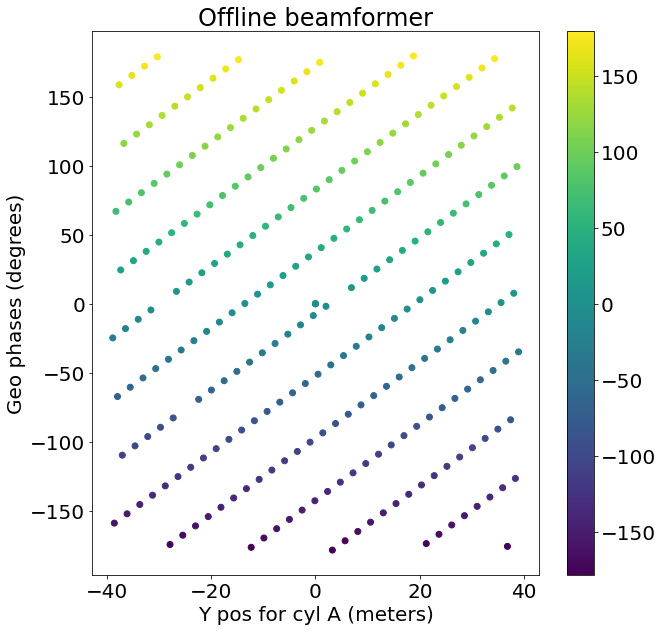

In [452]:
plt.scatter(np.array(cylA)[:,1], angle, c = angle)
plt.colorbar()
plt.xlabel("Y pos for cyl A (meters)")
plt.ylabel("Geo phases (degrees)")
plt.title("Offline beamformer")
plt.savefig("Offline_BF_geo_phases.png")
#plt.xlim(-35, -30)

In [456]:
np.array(cylA)[:,1]

array([-38.82107711, -38.51627734, -38.21147758, -37.90667781,
       -37.60187804, -37.29707828, -36.99227851, -36.68747875,
       -36.38267898, -36.07787921, -35.77307945, -35.46827968,
       -35.16347992, -34.85868015, -34.55388038, -34.24908062,
       -33.94428085, -33.63948109, -33.33468132, -33.02988155,
       -32.72508179, -32.42028202, -32.11548226, -31.81068249,
       -31.50588272, -31.20108296, -30.89628319, -30.59148343,
       -30.28668366, -29.98188389, -29.67708413, -29.37228436,
         0.        , -28.76268483, -28.45788507, -28.1530853 ,
       -27.84828553, -27.54348577, -27.238686  , -26.93388624,
       -26.62908647, -26.3242867 , -26.01948694, -25.71468717,
       -25.40988741, -25.10508764,   0.        , -24.49548811,
       -24.19068834, -23.88588858, -23.58108881, -23.27628904,
       -22.97148928, -22.66668951, -22.36188975, -22.05708998,
       -21.75229021, -21.44749045, -21.14269068, -20.83789092,
       -20.53309115, -20.22829138, -19.92349162, -19.61